## Importing Graph Edges

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
from cleaner import get_distinct_colors, get_community_dict, generate_negative_samples, getFeatures, preprocess, split_graph, evaluate_model, print_feature_importances
import random

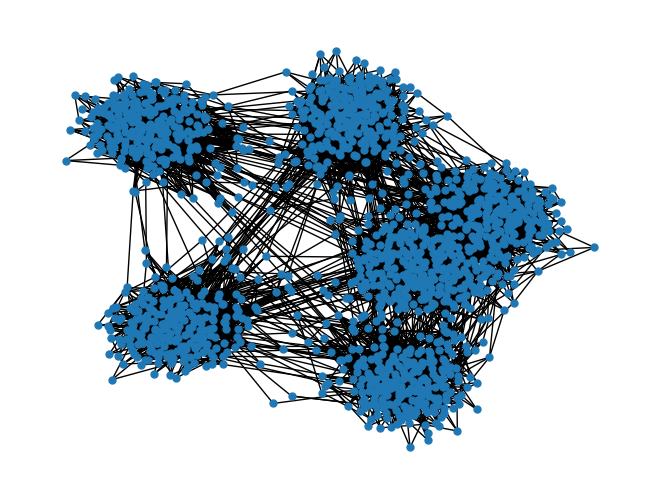

In [2]:
G = nx.read_edgelist("assignment2_files_2024/edges_train.edgelist", data=False, nodetype = int, delimiter=',') # import
pos = nx.spring_layout(G)
nx.draw(G, pos=pos, node_size=25)

In [3]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Node attributes example:", list(G.nodes(data=True))[:5])

Number of nodes: 1500
Number of edges: 6600
Node attributes example: [(0, {}), (5, {}), (6, {}), (7, {}), (8, {})]


## Setting Node Attributes

In [4]:
attributes = pd.read_csv("assignment2_files_2024/attributes.csv").set_index("ID").to_dict()["attribute"]

In [5]:
nx.set_node_attributes(G, attributes, "attribute")
for node, data in list(G.nodes(data=True))[:5]:
    print(f"Node: {node}, Attribute: {data}")

Node: 0, Attribute: {'attribute': 'l'}
Node: 5, Attribute: {'attribute': 'x'}
Node: 6, Attribute: {'attribute': 'x'}
Node: 7, Attribute: {'attribute': 'x'}
Node: 8, Attribute: {'attribute': 'x'}


## Exploring Graph Communities

/Users/jeremypalmerio/opt/miniconda3/envs/FDS-2/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


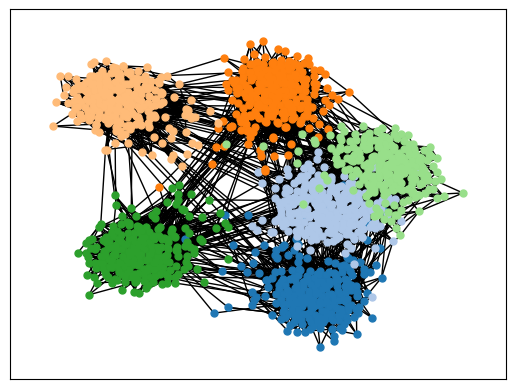

In [6]:
from networkx.algorithms.community import greedy_modularity_communities

c = list(greedy_modularity_communities(G, resolution=1))
colors = get_distinct_colors(len(c))
for community, color in zip(c, colors):
      nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=color, node_size=25)
nx.draw_networkx_edges(G, pos)

In [7]:
community_dict = get_community_dict(G)
nx.set_node_attributes(G, community_dict, "community")

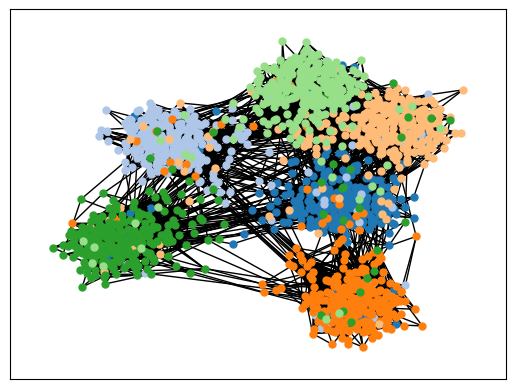

In [8]:
unique_attr = list(set(attributes.values()))
colors = get_distinct_colors(len(unique_attr))

pos = nx.spring_layout(G)
for attr, color in zip(unique_attr, colors):
    nodes = [x for x,y in G.nodes(data=True) if y['attribute']==attr]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, node_size=25)
nx.draw_networkx_edges(G, pos)

## Sensitive Attribute Distribution

In [9]:
for attr in unique_attr:
    nodes = [x for x,y in G.nodes(data=True) if y['attribute']==attr]
    print(attr, len(nodes))

y 250
f 250
l 250
d 250
m 250
x 250


## Fitting Classifier

### Splitting Training and Testing Sets

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
G_train, test_edges = split_graph(G)

### Feature Engineering

In [26]:
features = ['i', 'j', 'degree_i', 'degree_j', 'pa_score', 'common_neighbors', 'jaccard_score',
                                 'adamic_adar_score', 'resource_allocation_score', 'attribute_score', 'triadic_score', 'community_score', 'soundarajan'    
            ]
G_positive_train = pd.DataFrame((G_train.edges()), columns=['i', 'j'])
G_negative_train = generate_negative_samples(G_train, G_train.number_of_edges())
X_train, y_train = preprocess(G_train, G_positive_train, G_negative_train, training=True, features=features)

G_positive_test = pd.DataFrame(test_edges, columns=['i', 'j'])
G_negative_test = generate_negative_samples(G, len(test_edges))
X_test, y_test = preprocess(G_train, G_positive_test, G_negative_test, training=True, features=features)

preprocessing training
preprocessing training


In [18]:
X_train

,i,j,degree_i,degree_j,pa_score,common_neighbors,jaccard_score,adamic_adar_score,resource_allocation_score,triadic_score,attribute_score,community_score,soundarajan
0,0,5,37,56,2072,12,0.148148,5.728960,1.491992,12,0,1,24
1,0,6,37,14,518,3,0.062500,1.350659,0.342857,3,0,1,6
2,0,7,37,64,2368,11,0.122222,5.393522,1.453351,11,0,1,22
3,0,8,37,17,629,3,0.058824,0.943994,0.144593,3,0,1,6
4,0,9,37,33,1221,6,0.093750,2.594890,0.628262,6,0,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5276,92,987,4,3,12,0,0.000000,0.000000,0.000000,0,0,0,0
5277,1244,1251,4,30,120,0,0.000000,0.000000,0.000000,0,0,0,0
5278,696,952,3,5,15,0,0.000000,0.000000,0.000000,0,0,0,0
5279,1387,137,4,4,16,0,0.000000,0.000000,0.000000,0,0,0,0


### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
# 
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfc = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_rfc = grid_search.best_estimator_



Fitting 5 folds for each of 135 candidates, totalling 675 fits


In [69]:
grid_search.best_params_

{'max_depth': 5,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 20}

### Logisitic Regression


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


scaler = StandardScaler()
clf = LogisticRegression(random_state=0)


param_grid = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
pipe = Pipeline([('scaler', scaler), ('lr', clf)])

grid_search = GridSearchCV(pipe, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_


Fitting 5 folds for each of 7 candidates, totalling 35 fits


### XGBoost

In [64]:
from xgboost import XGBClassifier


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001 ],
    'subsample': [0.5, 0.6, 0.7],
    'gamma': [0, 0.01, 0.1,],                    # Minimum loss reduction to make a split
    'reg_alpha': [0, 0.001],                     # L1 regularization term on weights
    'reg_lambda': [0.5, 1, 1.5]      
    
}
xgb_model = XGBClassifier()

xgb_grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the training data
xgb_grid.fit(X_train, y_train)

best_xgb = xgb_grid.best_estimator_

Fitting 5 folds for each of 2430 candidates, totalling 12150 fits

[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0, reg_lambda=0.5, subsample=0.7; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0, reg_lambda=1.5, subsample=0.7; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0.001, reg_lambda=0.5, subsample=0.5; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0.001, reg_lambda=0.5, subsample=0.5; total time=   0.1s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0.001, reg_lambda=0.5, subsample=0.5; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0.001, reg_lambda=1.5, subsample=0.6; total time=   0.2s
[CV] END gamma=0.1, learning_rate=0.05, max_depth=3, n_estimators=200, reg_alpha=0.001, reg_lambda=1.5, subsample

In [65]:
xgb_best_params = xgb_grid.best_params_
print(xgb_best_params)

{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.5}


## Model Evaluation 

### Random Forest


Best model performance:
0.833 Train accuracy with a standard deviation of 0.09
0.878 Test accuracy with a standard deviation of 0.02

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85      1319
           1       0.90      0.75      0.82      1319

    accuracy                           0.83      2638
   macro avg       0.84      0.83      0.83      2638
weighted avg       0.84      0.83      0.83      2638


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x16695ec30>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x167fd8290>)

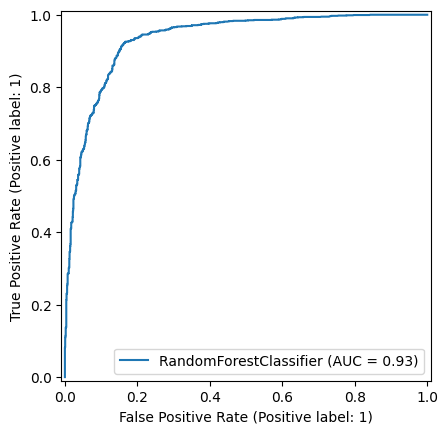

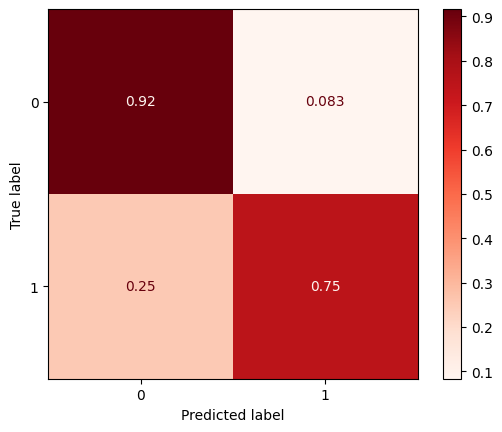

In [347]:
evaluate_model(best_rfc, X_test, y_test, X_train, y_train)

### Logistic Regression


Best model performance:
0.874 Train accuracy with a standard deviation of 0.02
0.874 Test accuracy with a standard deviation of 0.01

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1319
           1       0.84      0.92      0.88      1319

    accuracy                           0.88      2638
   macro avg       0.88      0.88      0.88      2638
weighted avg       0.88      0.88      0.88      2638


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x157d48590>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x157e918e0>)

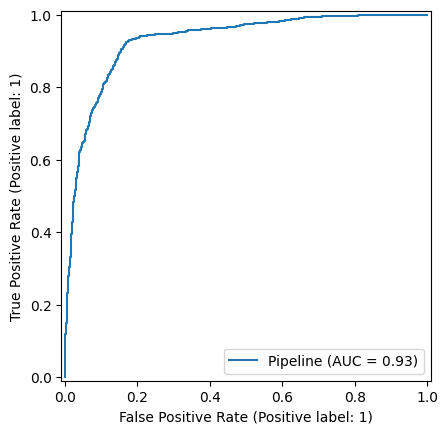

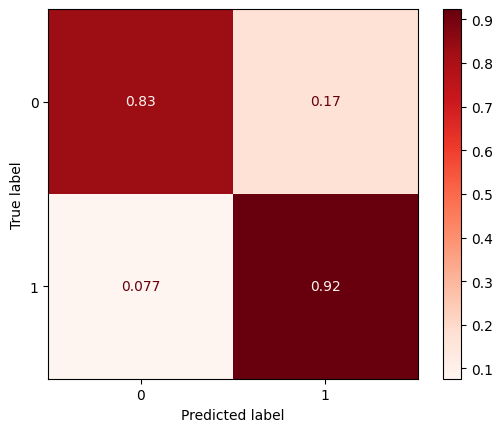

In [31]:
evaluate_model(best_lr, X_test, y_test, X_train, y_train)

### XGBoost


Best model performance:
0.810 Train accuracy with a standard deviation of 0.14
0.878 Test accuracy with a standard deviation of 0.01

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1319
           1       0.87      0.86      0.86      1319

    accuracy                           0.86      2638
   macro avg       0.86      0.86      0.86      2638
weighted avg       0.86      0.86      0.86      2638


(<sklearn.metrics._plot.roc_curve.RocCurveDisplay at 0x15b1ef200>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x156f1da30>)

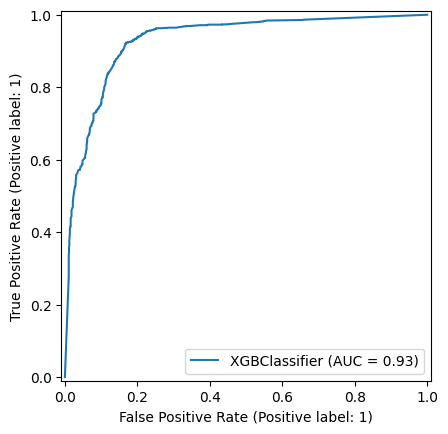

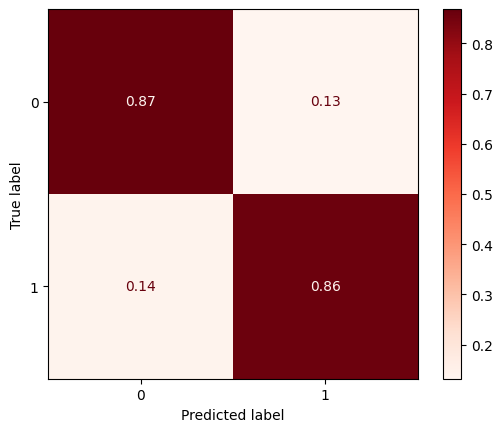

In [66]:
evaluate_model(best_xgb, X_test, y_test, X_train, y_train)


### Feature Importance

In [70]:
print_feature_importances(best_rfc, X_train.columns)

                      Feature  Importance
11            community_score    0.388329
10            attribute_score    0.178543
6               jaccard_score    0.110794
2                    degree_i    0.074162
12                soundarajan    0.048873
4                    pa_score    0.048107
7           adamic_adar_score    0.044458
8   resource_allocation_score    0.035217
5            common_neighbors    0.023179
9               triadic_score    0.018338
1                           j    0.014140
0                           i    0.010896
3                    degree_j    0.004963


### Evaluation per Sensitive Attribute Pairs

## Predicting Solution Set

In [33]:
G_positive = pd.DataFrame((G.edges()), columns=['i', 'j'])
G_negative = generate_negative_samples(G, G.number_of_edges())
X, y = preprocess(G, G_positive, G_negative, training=True, features=features)


preprocessing training


In [34]:
best_model = XGBClassifier(**xgb_best_params)
best_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.01, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [333]:
solutions = pd.read_csv('assignment2_files_2024/solutionInput.csv')
solutions = solutions.rename(columns={'int1':'i', 'int2':'j'})


In [334]:
solutions

,ID,i,j
0,0,56,396
1,1,760,853
2,2,340,1137
3,3,597,771
4,4,1355,1410
...,...,...,...
1461,1461,342,828
1462,1462,1066,1103
1463,1463,375,1376
1464,1464,1017,1350


In [335]:
X_solution = preprocess(G, solutions[['i', 'j']], features=features)
X_solution

preprocessing testing


,i,j,degree_i,degree_j,pa_score,common_neighbors,jaccard_score,adamic_adar_score,resource_allocation_score,triadic_score,attribute_score,community_score,soundarajan
0,56,396,6,5,30,0,0.000000,0.000000,0.000000,0,0,0,0
1,760,853,37,6,222,2,0.048780,0.809981,0.185535,2,1,1,4
2,340,1137,7,7,49,0,0.000000,0.000000,0.000000,0,0,0,0
3,597,771,7,15,105,0,0.000000,0.000000,0.000000,0,0,0,0
4,1355,1410,7,5,35,0,0.000000,0.000000,0.000000,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1461,342,828,7,7,49,0,0.000000,0.000000,0.000000,0,0,0,0
1462,1066,1103,10,7,70,1,0.062500,0.369269,0.066667,1,1,1,2
1463,375,1376,6,4,24,0,0.000000,0.000000,0.000000,0,0,0,0
1464,1017,1350,17,9,153,0,0.000000,0.000000,0.000000,0,0,0,0


In [336]:
y_pred_solution = pd.Series(best_model.predict(X_solution))
sum(y_pred_solution), len(y_pred_solution)

(762, 1466)

In [337]:
solutions['prediction'] = y_pred_solution

In [338]:
solutions.drop(columns=['i', 'j']).to_csv('solution_predictions.csv', index=False)

## Fairlearn Evaluation

In [35]:
# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, 
    demographic_parity_difference, 
    demographic_parity_ratio,
    false_positive_rate, 
    false_negative_rate,
    false_positive_rate_difference, 
    false_negative_rate_difference,
    equalized_odds_difference)

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [36]:
attr_i_train = X_train['i'].map(lambda node: G.nodes[node].get('attribute'))
attr_j_train = X_train['j'].map(lambda node: G.nodes[node].get('attribute'))

attr_i_test = X_test['i'].map(lambda node: G.nodes[node].get('attribute'))
attr_j_test = X_test['j'].map(lambda node: G.nodes[node].get('attribute'))


In [37]:
attr_dict = {
 'xx': 'xx',
 'xm': 'mx',
 'xl': 'lx',
 'xf': 'fx',
 'xy': 'xy',
 'xd': 'dx',
 'mx': 'mx',
 'mm': 'mm',
 'ml': 'lm',
 'mf': 'fm',
 'my': 'my',
 'md': 'dm',
 'lx': 'lx',
 'lm': 'lm',
 'll': 'll',
 'lf': 'fl',
 'ly': 'ly',
 'ld': 'dl',
 'fx': 'fx',
 'fm': 'fm',
 'fl': 'fl',
 'ff': 'ff',
 'fy': 'fy',
 'fd': 'df',
 'yx': 'xy',
 'ym': 'my',
 'yl': 'ly',
 'yf': 'fy',
 'yy': 'yy',
 'yd': 'dy',
 'dx': 'dx',
 'dm': 'dm',
 'dl': 'dl',
 'df': 'df',
 'dy': 'dy',
 'dd': 'dd'
}

In [38]:
X_train['attribute_pair'] = [i+j for i, j in zip(attr_i_train, attr_j_train)]
X_train['attribute_pair'] = X_train['attribute_pair'].replace(attr_dict)

X_test['attribute_pair'] = [i+j for i, j in zip(attr_i_test, attr_j_test)]
X_test['attribute_pair'] = X_test['attribute_pair'].replace(attr_dict)

In [53]:
A_str_test = X_test['attribute_pair']
A_str_train = X_train['attribute_pair']
X_test.drop(columns='attribute_pair', inplace=True)
X_train.drop(columns='attribute_pair', inplace=True)


In [55]:
y_pred = best_model.predict(X_test)

In [56]:
metrics_dict = {
        "Overall selection rate":  selection_rate(y_test, y_pred, pos_label=0),
        "Demographic parity difference": demographic_parity_difference(y_test, y_pred, sensitive_features=A_str_test),
        "Demographic parity ratio": demographic_parity_ratio(y_test, y_pred, sensitive_features=A_str_test),
        "------": "",
        "False positive rate difference": false_positive_rate_difference(y_test, y_pred, sensitive_features=A_str_test),
        "False negative rate difference": false_negative_rate_difference(y_test, y_pred, sensitive_features=A_str_test),
        "Equalized odds difference": equalized_odds_difference(y_test, y_pred, sensitive_features=A_str_test),
         "-------": "",
        "Overall AUC": roc_auc_score(y_test, y_pred),
        "AUC difference": MetricFrame(metrics=roc_auc_score, y_true=y_test, y_pred=y_pred, sensitive_features=A_str_test).difference(method='between_groups'),
    }

pd.DataFrame.from_dict(metrics_dict, orient="index", columns=["Metrics"])

,Metrics
Overall selection rate,0.573541
Demographic parity difference,0.665913
Demographic parity ratio,0.125706
------,
False positive rate difference,0.5
False negative rate difference,0.54786
Equalized odds difference,0.54786
-------,
Overall AUC,0.836998
AUC difference,0.263613


In [57]:
postprocess_est = ThresholdOptimizer(
    estimator=best_xgb,
    constraints="equalized_odds",
    prefit=True,
    predict_method='predict')

In [58]:
postprocess_est.fit(X_train, y_train, sensitive_features=A_str_train)

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=0.01, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.1, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=3,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   predict_method='predict', prefit=True)

In [60]:
postprocess_preds = postprocess_est.predict(X_test, sensitive_features=A_str_test)

In [61]:
metrics_dict = {
        "Overall selection rate":  selection_rate(y_test, postprocess_preds, pos_label=0),
        "Demographic parity difference": demographic_parity_difference(y_test, postprocess_preds, sensitive_features=A_str_test),
        "Demographic parity ratio": demographic_parity_ratio(y_test, postprocess_preds, sensitive_features=A_str_test),
        "------": "",
        "False positive rate difference": false_positive_rate_difference(y_test, postprocess_preds, sensitive_features=A_str_test),
        "False negative rate difference": false_negative_rate_difference(y_test, postprocess_preds, sensitive_features=A_str_test),
        "Equalized odds difference": equalized_odds_difference(y_test, postprocess_preds, sensitive_features=A_str_test),
         "-------": "",
        "Overall AUC": roc_auc_score(y_test, postprocess_preds),
        "AUC difference": MetricFrame(metrics=roc_auc_score, y_true=y_test, y_pred=postprocess_preds, sensitive_features=A_str_test).difference(method='between_groups'),
    }

pd.DataFrame.from_dict(metrics_dict, orient="index", columns=["Metrics"])

,Metrics
Overall selection rate,0.309325
Demographic parity difference,0.23983
Demographic parity ratio,0.693462
------,
False positive rate difference,0.219817
False negative rate difference,0.317739
Equalized odds difference,0.317739
-------,
Overall AUC,0.619788
AUC difference,0.1781
